### 线性回归
这个笔记添加了一些注释和个人对代码的理解

In [1]:
import torch
import time

In [2]:
n=1000
a=torch.ones(n) # 生成1000维大小为一的标量
b=torch.ones(n)

In [3]:
# timer class
class Timer (object):
    def __init__(self): #python的构造函数
        self.times=[]   #self.XXX 定义python类的变量
        self.start()
    
    def start(self):
        self.start_time = time.time()
        
    def stop(self):
        self.times.append(time.time() - self.start_time) # append 类似于c++数组的push_back 在尾部添加元素
        return self.times[-1]                           # [-1] 取倒数第一位
    
    def avg(self):
        return sum(self.times)/len(self.times)          # 计算平均运行时长
    
    def sum(self):
        return sum(self.times)

1, 用for循环作标量加法

In [4]:
timer = Timer()
c=torch.zeros(n) # 生成1000维大小为0的标量
for i in range(n) :
    c[i] = a[i]+b[i]
print(timer.stop())

0.04383969306945801


2,用pytorch运行标量加法

In [5]:
timer.start()
d=a+b
'%.5f sec'% timer.stop()

'0.00000 sec'

显然pytorch更快

#### 下面用tenserflow 运行同样代码

In [6]:
import tensorflow as tf

In [7]:
tf_a = tf.ones(n)
tf_b = tf.ones(n)

In [8]:
timer.start()
tf_d=a+b
'%.5f sec'% timer.stop()

'0.00000 sec'

显然pytorch与tenserflow 不分彼此

## 线性回归模型从零开始

In [2]:
%matplotlib inline
import torch
from IPython import display  
from matplotlib import pyplot as plt #散点图
import numpy as np
import random

print(torch.__version__)

1.4.0


In [3]:
num_inputs = 2
num_examples = 1000

true_w = [2, -3.4]
true_b = 4.2

features = torch.randn(num_examples, num_inputs,dtype=torch.float32)  #随机生成1000*2的数据
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()),dtype=torch.float32) # 为结果加入随机偏差 模拟真实数据

图像展示

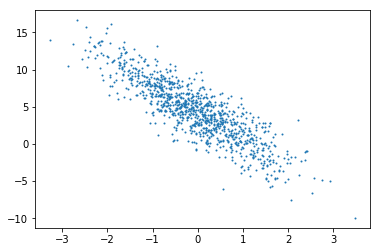

In [4]:
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);

读取数据集

In [5]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples)) #生成一个与数据长度相等的序列【0--num_examples】 并转换成列表
    random.shuffle(indices)  # 将序列随机重新排序
    for i in range(0, num_examples, batch_size): #for循环 i从0到num_examples 步长是 batch_size
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # 每次循环取batch_size个序列
        yield  features.index_select(0, j), labels.index_select(0, j)   
        # index_select()参数0指行，1指列  
        # 输出j中序列代表的行，从而实现随机读取数据

In [13]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break           # 跳出循环 只输出10个数据

tensor([[ 0.5536,  0.1213],
        [ 2.2359, -2.0172],
        [ 1.1767, -1.3213],
        [-0.2732,  0.1535],
        [-2.1978,  0.1922],
        [-0.3637,  1.0271],
        [-0.9810,  1.5348],
        [ 1.1957,  0.7572],
        [-0.3323,  0.9395],
        [-1.2617, -0.8727]]) 
 tensor([ 4.8934, 15.5179, 11.0384,  3.1352, -0.8537, -0.0161, -2.9755,  4.0205,
         0.3548,  4.6584])


初始化模型参数

In [7]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32) #利用正态分布随机成成2*1的参数
b = torch.zeros(1, dtype=torch.float32)

w.requires_grad_(requires_grad=True)   #通过该参数来设置是否对该变量求导 （梯度下降法）
b.requires_grad_(requires_grad=True)

tensor([0.], requires_grad=True)

定义模型

In [8]:
def linreg(X, w, b):
    return torch.mm(X, w) + b  #torch.mm() 矩阵相乘  n行2列的矩阵X 乘 2行1列矩阵w =》n行一列矩阵   即X1*w1+X2*w2+b

定义损失函数 使用均方误差

In [10]:
def squared_loss(y_hat, y): 
    return (y_hat - y.view(y_hat.size())) ** 2 / 2  # y.view(y_hat.size()) y只有一行，将y转换成与y_hat相同行数的列向量

定义小批量随机下降  优化函数

In [11]:
def sgd(params, lr, batch_size): 
    for param in params:
        param.data -= lr * param.grad / batch_size # .data 返回和 x 的相同数据 tensor, 但不会加入到x的计算历史里

训练

In [14]:
# 超参数 超参数指模型无法自动调参需要手动设置的参数
lr = 0.03
num_epochs = 5

net = linreg
loss = squared_loss

# training
for epoch in range(num_epochs):  # training repeats num_epochs times
    # in each epoch, all the samples in dataset will be used once
    
    # X is the feature and y is the label of a batch sample
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()  
        # calculate the gradient of batch sample loss 
        l.backward()  #反向传播 计算梯度
        # using small batch random gradient descent to iter model parameters
        sgd([w, b], lr, batch_size)  
        # reset parameter gradient
        #  grad在反向传播过程中是累加的(accumulated)，这意味着每一次运行反向传播，梯度都会累加之前的梯度，所以一般在反向传播之前需把梯度清零。
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.024333
epoch 2, loss 0.000081
epoch 3, loss 0.000047
epoch 4, loss 0.000048
epoch 5, loss 0.000047


In [15]:
w, true_w, b, true_b

(tensor([[ 2.0003],
         [-3.3989]], requires_grad=True),
 [2, -3.4],
 tensor([4.2000], requires_grad=True),
 4.2)

### 线性回归pytorch实现

In [1]:
import torch
from torch import nn
import numpy as np
torch.manual_seed(1)

print(torch.__version__)
torch.set_default_tensor_type('torch.FloatTensor')

1.4.0


数据集 和上面一样

In [2]:
num_inputs = 2
num_examples = 1000

true_w = [2, -3.4]
true_b = 4.2

features = torch.tensor(np.random.normal(0, 1, (num_examples, num_inputs)), dtype=torch.float)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

读取数据集

In [3]:
#  PyTorch提供了data包来读取数据。由于data常用作变量名，我们将导入的data模块用Data代替。在每一次迭代中，我们将随机读取包含10个数据样本的小批量。
import torch.utils.data as Data

batch_size = 10

# combine featues and labels of dataset
dataset = Data.TensorDataset(features, labels)

# put dataset into DataLoader
data_iter = Data.DataLoader(
    dataset=dataset,            # torch TensorDataset format
    batch_size=batch_size,      # mini batch size
    shuffle=True,               # whether shuffle the data or not
    num_workers=2,              # read data in multithreading
)

In [4]:
for X, y in data_iter:
    print(X, '\n', y)
    break

tensor([[ 1.4284,  0.3224],
        [-0.6120,  0.5307],
        [ 0.1511, -1.9899],
        [-0.0486,  0.4757],
        [ 1.2438, -1.3689],
        [ 0.4543,  0.7067],
        [ 1.6300,  1.7061],
        [ 0.9088, -0.7688],
        [ 0.7028, -0.7059],
        [-0.5255, -0.6703]]) 
 tensor([ 5.9552,  1.1702, 11.2862,  2.5107, 11.3590,  2.6873,  1.6673,  8.6199,
         8.0162,  5.4509])


定义模型

In [6]:
class LinearNet(nn.Module): # 继承nn.modul
    def __init__(self, n_feature):
        super(LinearNet, self).__init__()      # call father function to init  官方文档也是这样写的，具体含义不晓得
        self.linear = nn.Linear(n_feature, 1)  # function prototype: `torch.nn.Linear(in_features, out_features, bias=True)`
                                               # 线性回归成为当前modul的子模块，成为树结构的一个叶子。
    def forward(self, x):
        y = self.linear(x)
        return y
    
net = LinearNet(num_inputs)
print(net)

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


构建神经网络

In [7]:
# Sequential是一个有序的容器，网络层将按照在传入Sequential的顺序依次被添加到计算图中。
# 一种顺序容器。传入Sequential构造器中的模块会被按照他们传入的顺序依次添加到Sequential之上。
# 相应的，一个由模块组成的顺序词典也可以被传入到Sequential的构造器中。
# 写法一
net = nn.Sequential(
    nn.Linear(num_inputs, 1)
    # 此处还可以传入其他层
    )

# 写法二
net = nn.Sequential()
net.add_module('linear', nn.Linear(num_inputs, 1))
# net.add_module ......

# 写法三
from collections import OrderedDict
net = nn.Sequential(OrderedDict([
          ('linear', nn.Linear(num_inputs, 1))
          # ......
        ]))

print(net)
print(net[0])

Sequential(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Linear(in_features=2, out_features=1, bias=True)


初始化参数

In [8]:
from torch.nn import init

init.normal_(net[0].weight, mean=0.0, std=0.01)  #正态初始化
init.constant_(net[0].bias, val=0.0)  # or you can use `net[0].bias.data.fill_(0)` to modify it directly
                                      # 常量初始化 ，依然不明白.data
# net[0] 根据下标访问子模块，仅当net是moduleList 或者 Sequential 实例时才可用

Parameter containing:
tensor([0.], requires_grad=True)

In [9]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[-0.0142, -0.0161]], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)


损失函数

In [10]:
loss = nn.MSELoss()    # nn built-in squared loss function
                       # function prototype: `torch.nn.MSELoss(size_average=None, reduce=None, reduction='mean')`
# 均方误差

优化函数

In [11]:
# torch.optim模块提供了很多常用的优化算法比如SGD、Adam和RMSProp等
#下面我们创建一个用于优化net所有参数的优化器实例，并指定学习率为0.03的小批量随机梯度下降（SGD）为优化算法。
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.03)   # built-in random gradient descent function
print(optimizer)  # function prototype: `torch.optim.SGD(params, lr=, momentum=0, dampening=0, weight_decay=0, nesterov=False)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


训练模型

In [12]:
num_epochs = 3
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        output = net(X)
        l = loss(output, y.view(-1, 1))  # 等价于  上面l = loss(net(X, w, b), y).sum() 
        optimizer.zero_grad() # reset gradient, equal to net.zero_grad()
        l.backward()
        optimizer.step()
    print('epoch %d, loss: %f' % (epoch, l.item()))

epoch 1, loss: 0.000201
epoch 2, loss: 0.000067
epoch 3, loss: 0.000060


In [13]:
dense = net[0] #取参
print(true_w, dense.weight.data)
print(true_b, dense.bias.data)

[2, -3.4] tensor([[ 2.0003, -3.3989]])
4.2 tensor([4.2006])
